In [1]:
# Cell 1: Imports and setup
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Cell 2: Configuration and paths
ARTIFACT_DIR = "model_artifacts"  # Adjust if placed elsewhere
CKPT_PATH = os.path.join(ARTIFACT_DIR, "multitask_cnn_lstm.pth")
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.json")
ACTIONS_PATH = os.path.join(ARTIFACT_DIR, "action_labels.json")

# Set this to your test image path
IMG_PATH = "E:/Dogeating.jpg"

# Verify paths
print("Checking artifact paths...")
print(f"Checkpoint exists: {os.path.isfile(CKPT_PATH)}")
print(f"Vocabulary exists: {os.path.isfile(VOCAB_PATH)}")
print(f"Actions exists: {os.path.isfile(ACTIONS_PATH)}")
print(f"Test image exists: {os.path.isfile(IMG_PATH)}")

Checking artifact paths...
Checkpoint exists: True
Vocabulary exists: True
Actions exists: True
Test image exists: True


In [16]:
# Cell 3: Define model architecture (SharedResNet50 backbone)
class SharedResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        try:
            resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        except Exception:
            resnet = models.resnet50(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # Remove final FC layer
        self.out_dim = 2048
    
    def forward(self, x):
        f = self.backbone(x)  # (N, 2048, 1, 1)
        return f.view(f.size(0), -1)  # (N, 2048)

print("SharedResNet50 defined")

SharedResNet50 defined


In [17]:
# Cell 4: Define action classification head
class ActionHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

print("ActionHead defined")

ActionHead defined


In [18]:
# Cell 5: Define LSTM caption decoder
class CaptionDecoder(nn.Module):
    def __init__(self, in_dim, vocab_size, embed_dim, hidden_dim, num_layers, pad_id):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.to_h0 = nn.Linear(in_dim, hidden_dim)
        self.to_c0 = nn.Linear(in_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, vocab_size)
        self.num_layers = num_layers
    
    def forward(self, img_feat, captions_in):
        emb = self.embed(captions_in)
        h0 = torch.tanh(self.to_h0(img_feat))
        c0 = torch.tanh(self.to_c0(img_feat))
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = c0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        out_seq, _ = self.lstm(emb, (h0, c0))
        logits = self.out(out_seq)
        return logits

print("CaptionDecoder defined")

CaptionDecoder defined


In [19]:
# Cell 6: Define multi-task model
class MultiTaskModel(nn.Module):
    def __init__(self, num_actions, vocab_size, embed_dim, hidden_dim, num_layers, pad_id):
        super().__init__()
        self.cnn = SharedResNet50()
        self.action_head = ActionHead(self.cnn.out_dim, num_actions)
        self.caption_head = CaptionDecoder(self.cnn.out_dim, vocab_size, embed_dim, hidden_dim, num_layers, pad_id)
    
    def forward(self, images, captions_in):
        img_feat = self.cnn(images)
        action_logits = self.action_head(img_feat)
        caption_logits = self.caption_head(img_feat, captions_in)
        return action_logits, caption_logits

print("MultiTaskModel defined")

MultiTaskModel defined


In [20]:
# Cell 7: Load artifacts and rebuild model
print("Loading artifacts...")

# Load checkpoint
ckpt = torch.load(CKPT_PATH, map_location=device)
conf = ckpt["config"]
print(f"Config: {conf}")

# Load vocabulary
with open(VOCAB_PATH, "r", encoding="utf-8") as f:
    vdata = json.load(f)

# Load action classes
with open(ACTIONS_PATH, "r", encoding="utf-8") as f:
    action_classes = json.load(f)

print(f"Action classes: {action_classes}")
print(f"Vocabulary size: {len(vdata['itos'])}")

# Extract vocab pieces
pad_id = int(conf["pad_id"])
sos_id = int(conf["sos_id"])
eos_id = int(conf["eos_id"])
itos = vdata["itos"]

print(f"Special tokens - PAD: {pad_id}, SOS: {sos_id}, EOS: {eos_id}")

# Rebuild model
print("\nRebuilding model...")
model = MultiTaskModel(
    num_actions=len(action_classes),
    vocab_size=int(conf["vocab_size"]),
    embed_dim=int(conf["embed_dim"]),
    hidden_dim=int(conf["hidden_dim"]),
    num_layers=int(conf["num_lstm_layers"]),
    pad_id=pad_id,
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("Model loaded and set to eval mode")

Loading artifacts...
Config: {'embed_dim': 256, 'hidden_dim': 512, 'num_lstm_layers': 1, 'max_seq_len': 20, 'num_actions': 7, 'vocab_size': 3257, 'pad_id': 0, 'sos_id': 1, 'eos_id': 2, 'unk_id': 3}
Action classes: ['walking', 'running', 'sitting', 'standing', 'riding', 'playing', 'eating']
Vocabulary size: 3257
Special tokens - PAD: 0, SOS: 1, EOS: 2

Rebuilding model...
Model loaded and set to eval mode


In [21]:
# Cell 8: Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image preprocessing pipeline ready")

Image preprocessing pipeline ready


Loading image: E:/Dogeating.jpg
Original image size: (1024, 576)


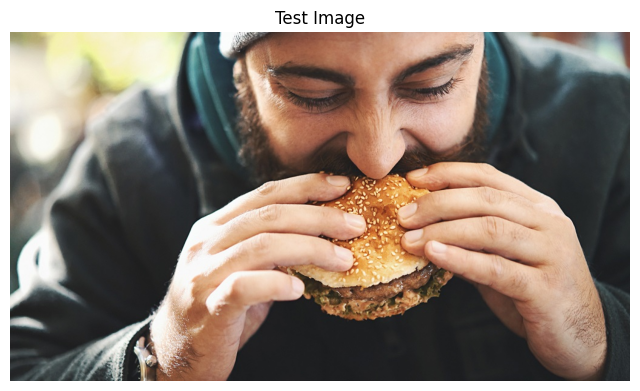

Preprocessed tensor shape: torch.Size([1, 3, 224, 224])


In [22]:
# Cell 9: Load and preprocess test image
assert os.path.isfile(IMG_PATH), f"Image not found: {IMG_PATH}. Please set IMG_PATH in Cell 2."

print(f"Loading image: {IMG_PATH}")
img = Image.open(IMG_PATH).convert("RGB")
print(f"Original image size: {img.size}")

# Display image (if in Jupyter with matplotlib)
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Test Image')
    plt.show()
except ImportError:
    print("(matplotlib not available for display)")

# Preprocess
img_t = transform(img).unsqueeze(0).to(device)
print(f"Preprocessed tensor shape: {img_t.shape}")

In [23]:
# Cell 10: Predict action
print("Predicting action...\n")

with torch.no_grad():
    action_logits, _ = model(img_t, torch.tensor([[sos_id]], device=device))
    probs = F.softmax(action_logits, dim=-1).squeeze(0).cpu()

# Get top-5 predictions
topk = torch.topk(probs, k=min(5, len(action_classes)))

print("=" * 50)
print("TOP ACTION PREDICTIONS:")
print("=" * 50)
for rank, (p, i) in enumerate(zip(topk.values.tolist(), topk.indices.tolist()), 1):
    print(f"{rank}. {action_classes[i]:12s} - {p*100:5.2f}%")
print("=" * 50)

Predicting action...

TOP ACTION PREDICTIONS:
1. eating       - 100.00%
2. sitting      -  0.00%
3. standing     -  0.00%
4. running      -  0.00%
5. playing      -  0.00%


In [24]:
# Cell 11: Generate caption (greedy decoding)
def generate_caption(model, img_t, itos, sos_id, eos_id, max_len):
    """Generate caption using greedy decoding."""
    with torch.no_grad():
        # Get image features
        img_feat = model.cnn(img_t)
        
        # Initialize LSTM hidden states from image features
        h0 = torch.tanh(model.caption_head.to_h0(img_feat))
        c0 = torch.tanh(model.caption_head.to_c0(img_feat))
        h = h0.unsqueeze(0).repeat(model.caption_head.num_layers, 1, 1)
        c = c0.unsqueeze(0).repeat(model.caption_head.num_layers, 1, 1)
        
        # Start with SOS token
        cur = torch.tensor([[sos_id]], device=img_t.device)
        out_tokens = []
        
        # Generate tokens one by one
        for _ in range(max_len):
            emb = model.caption_head.embed(cur)
            y, (h, c) = model.caption_head.lstm(emb, (h, c))
            logits = model.caption_head.out(y[:, -1, :])
            nxt = torch.argmax(logits, dim=-1).item()
            
            # Stop if EOS token
            if nxt == eos_id:
                break
            
            out_tokens.append(nxt)
            cur = torch.tensor([[nxt]], device=img_t.device)
        
        # Convert token IDs to words
        words = [itos[i] if i < len(itos) else "<UNK>" for i in out_tokens]
        return " ".join(words)

print("Generating caption...\n")
caption = generate_caption(
    model, 
    img_t, 
    itos, 
    sos_id, 
    eos_id, 
    max_len=int(conf.get("max_seq_len", 20))
)

print("=" * 50)
print("GENERATED CAPTION:")
print("=" * 50)
print(f"'{caption}'")
print("=" * 50)

Generating caption...

GENERATED CAPTION:
'a man eating a hot dog in a bun'


In [25]:
# Cell 12: Summary (optional)
print("\n" + "=" * 50)
print("INFERENCE SUMMARY")
print("=" * 50)
print(f"Image: {IMG_PATH}")
print(f"Top Action: {action_classes[topk.indices[0]]} ({topk.values[0]*100:.2f}%)")
print(f"Caption: {caption}")
print("=" * 50)


INFERENCE SUMMARY
Image: E:/Dogeating.jpg
Top Action: eating (100.00%)
Caption: a man eating a hot dog in a bun
